In [1]:
import sys
sys.path.append("../")

In [2]:
from datetime import datetime, timedelta
from functools import partial
from matplotlib.dates import DateFormatter
from ta import add_all_ta_features
from ta.utils import dropna
from utils.common_train_utils import *
from utils.draw_candle_image import *
from utils.evaluate_old_models import *
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
keras.config.enable_unsafe_deserialization()
from draw_image_utils import draw_prediction

In [3]:
symbol_mapping = {
    "CTG": {
        "dataset_folder": "ctg_dataset_0_2_3_2009_2024_test_2023_2024_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "FPT": {
        "dataset_folder": "fpt_dataset_0_2_3_2012_2024_test_2023_2024_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "TCB": {
        "dataset_folder": "tcb_dataset_0_2_3_2018_2024_test_2024_2024_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend",
        "freq_of_date": "B"
    },
    "VN30": {
        "dataset_folder": "vn30_dataset_0_2_3_2012_2024_test_2023_2024_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "B"
    },
    # "BTC": {
    #     "dataset_folder": "btc_dataset_0_2_3_2014_2024_test_2023_2024_with_ema_macd_trend",
    #     "model_name": "model_5_biLSTM_ema_macd_trend",
    #     "freq_of_date": "D"
    # },
    "BTC": {
        "dataset_folder": "btc_dataset_0_2_3_2014_2024_test_2024_2024_with_ema_macd_trend",
        "model_name": "model_5_biLSTM_ema_macd_trend_1_1_1_1_1_1",
        "freq_of_date": "D"
    },
    "COCA_COLA": {
        "dataset_folder": "coca_cola_dataset_0_2_3_1980_2024_test_2017_2024_with_ema_macd_trend",
        "model_name": "model_5_bi2LSTM_ema_macd_trend_1_1_1",
        "freq_of_date": "D"
    },
}

In [4]:

symbol = input("Symbol = ").strip().upper()
day_previous_from_now = int(input("Day previous from now = ").strip())
now = datetime.now() - timedelta(days=day_previous_from_now)
date_continue_learning = str(now.date()).replace("-", "_")

In [5]:

dataset_folder_name = symbol_mapping[symbol]["dataset_folder"]
model_name = symbol_mapping[symbol]["model_name"]
dataset_folder = f"../dataset/{dataset_folder_name}"
to_folder = f"to_{date_continue_learning}"
continue_learning_folder = f"{dataset_folder}/continue_learning/{to_folder}"
index_of_image_input = 3
batch_size = 100
freq_of_date = symbol_mapping[symbol]["freq_of_date"] # B or D

config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]


In [6]:
config_of_continue_learning_folder = read_config(continue_learning_folder)
file_csv_path = config_of_continue_learning_folder["file_csv"]
df_get_from_api = pd.read_csv(file_csv_path)
df_get_from_api["Date"] = pd.to_datetime(df_get_from_api["Date"])

In [7]:
def date_generator(date_i):
    index_of_date = get_date_index(df_get_from_api, date_i)
    total_days = previous_days + 1 + next_days + days_result
    all_dates = df_get_from_api[index_of_date:index_of_date + total_days]["Date"].dt.date
    total_date_reals = len(all_dates)
    dates_real = all_dates
    if len(all_dates) < total_days:
        all_dates = pd.date_range(start=str(date_i), periods=total_days, freq=freq_of_date)
    return list(all_dates), total_date_reals

In [8]:
function_transform_origin = get_origin_transform_function(
    os.path.join(
        os.path.abspath(f"{dataset_folder}/model_save/{model_name}"),
        "config_and_loss.json"
    )
)
path_of_model = f"{dataset_folder}/model_save/{model_name}/{model_name}.keras"
model = keras.models.load_model(os.path.abspath(path_of_model))


In [9]:
dataset_test = load_dataset_of_each_type_and_combine(continue_learning_folder, candle_type_and_directory_save)
total_data_test = len(dataset_test)


In [10]:
image_shape = get_image_shape(dataset_test, index_of_image_input)

In [11]:
dataset_test_1 = dataset_test
dataset_test_2 = dataset_test_1.batch(batch_size)
transform_function = partial(function_transform_origin, days_result)
dataset_test_3 = dataset_test_2.map(transform_function)

In [12]:
loss = model.evaluate(dataset_test_3)

d:\code\selenium\.venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ema_9_input', 'macd_history_input', 'trend_type_input', 'image_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - loss: 9.1136 - mae: 1.8488 - mse: 9.1136


In [13]:
loss

[9.113563537597656, 1.8488179445266724, 9.113563537597656]

In [14]:
prediction_for_test = model.predict(dataset_test_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


In [15]:
print(prediction_for_test)

[[[-1.48920691e+00 -1.42005515e+00]
  [-2.05694944e-01 -4.70884889e-03]
  [-1.74665093e-01  5.07845730e-02]]

 [[ 8.23017836e-01 -3.08159530e-01]
  [ 2.62097180e-01  1.49477988e-01]
  [ 1.67723104e-01  2.28372902e-01]]

 [[ 8.51805091e-01 -1.88510060e-01]
  [ 2.84586132e-01  1.55597061e-01]
  [ 1.77991390e-01  2.42283523e-01]]

 [[ 1.11653328e+00  8.80116671e-02]
  [ 3.84467155e-01  2.74600804e-01]
  [ 2.17267513e-01  2.82534003e-01]]

 [[ 8.23128223e-01 -3.07981908e-01]
  [ 2.62129962e-01  1.49497211e-01]
  [ 1.67746842e-01  2.28403553e-01]]

 [[ 1.35045421e+00  7.58605778e-01]
  [ 5.14083922e-01  3.82957995e-01]
  [ 2.73339242e-01  3.36796373e-01]]

 [[-5.17177105e-01 -1.32759666e+00]
  [-1.27352998e-01 -6.72584474e-02]
  [-6.43677711e-02  5.45368716e-02]]

 [[ 1.70157993e+00  3.54665327e+00]
  [ 6.02598548e-01  6.13794148e-01]
  [ 3.49819362e-01  5.51873326e-01]]

 [[-4.59336233e+00 -1.54799008e+00]
  [-5.84793806e-01  1.63975134e-01]
  [-4.01849985e-01  2.21567094e-01]]

 [[ 8.2160

In [16]:
len(prediction_for_test)

19

In [17]:
all_dates = unwrap_dataset_at_index(dataset_test, 5, to_numpy=True, map_function=lambda date: str(datetime.fromisoformat(date.decode("utf-8")).date()))
trend_dataset_test_2 = unwrap_dataset_at_index(unwrap_dataset_at_index(dataset_test_2, 2, batch=True, to_numpy=True), 0)
_4_prices_of_all_days_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 4, batch=True, to_numpy=True)
image_input_dataset_test_2 = unwrap_dataset_at_index(dataset_test_2, 3, batch=True, to_numpy=True)
real_percent_last_days_result_dataset_test_3 = unwrap_dataset_at_index(dataset_test_3, 1, batch=True, to_numpy=True) 

In [18]:
mapping_trend_type = {
    1: "GROUP_BULL",
    -1: "GROUP_BEAR",
    0: "GROUP_SIZEWAY",
}

real: [[ 0.         -4.76432442]
 [-4.98574004 -1.13289795]
 [ 3.05760212  0.        ]]
prediction: [[ 0.8518051  -0.18851006]
 [ 0.28458613  0.15559706]
 [ 0.17799139  0.24228352]]


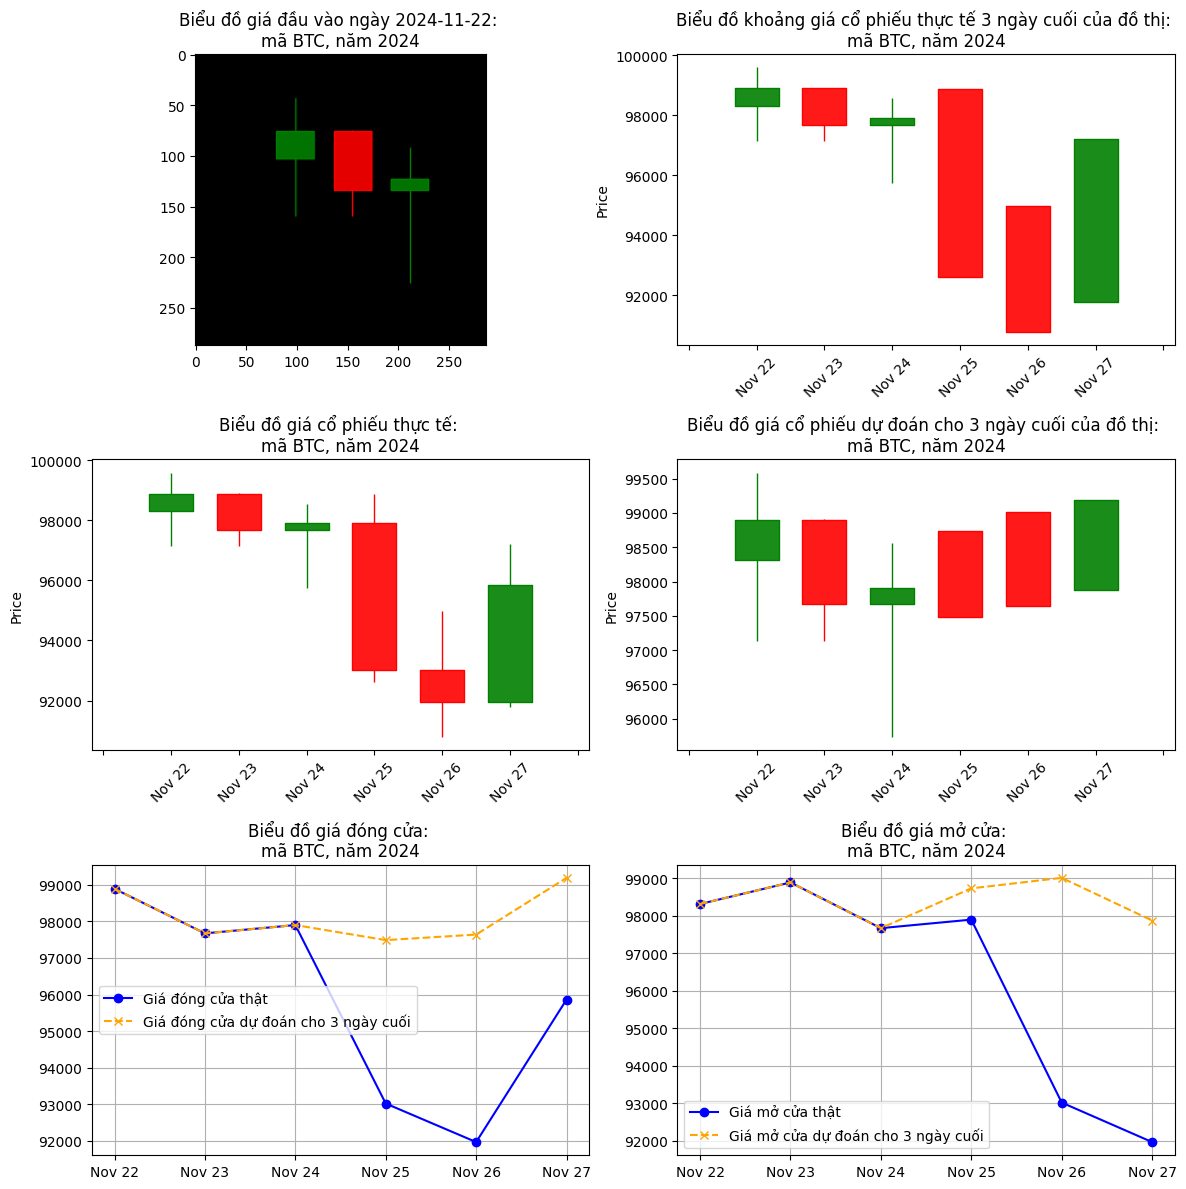

In [19]:
index = 2
print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
print(f"prediction: {prediction_for_test[index]}")
type_of_output = "open_and_close"
draw_prediction(
    image_input_dataset_test_2[index], 
    _4_prices_of_all_days_dataset_test_2[index], 
    all_dates[index],
    prediction_for_test[index], 
    show_x_orginal_candle=True,
    show_prediction_candle=True, 
    show_original_candle=True,
    show_close_compare=True,
    show_open_compare=True,
    type_of_output=type_of_output,
    draw_beside=True,
    print_image=True,
    extend_real=True,
    date_generator=date_generator,
    symbol=symbol)

In [20]:
# index = 0
is_print_all = input("Print all? (y/n): ").lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_all:
    group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
    is_extend_real = input("Extend real? (y/n): ").strip().lower()[0] == "y"
    
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
    
    folder_name = f"{to_folder}/{model_name}"
    if group is not None:
        folder_name += f"_{group}"
    
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/continue_learning/{folder_name}"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=True,
            show_prediction_candle=True, 
            show_original_candle=True,
            show_close_compare=True,
            show_open_compare=True,
            type_of_output=type_of_output,
            draw_beside=True,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            extend_real=is_extend_real,
            date_generator=date_generator,
            symbol=symbol,
            print_all_days_for_prediction=False)

---------------- Save: 0/19 images
real: [[ 0.72683657  0.        ]
 [ 0.          3.71616534]
 [-0.52005842 -0.79409302]]
prediction: [[-1.4892069  -1.4200552 ]
 [-0.20569494 -0.00470885]
 [-0.1746651   0.05078457]]
real: [[1.66580224 0.        ]
 [0.         0.79881669]
 [0.         0.        ]]
prediction: [[ 0.82301784 -0.30815953]
 [ 0.26209718  0.14947799]
 [ 0.1677231   0.2283729 ]]
real: [[ 0.         -4.76432442]
 [-4.98574004 -1.13289795]
 [ 3.05760212  0.        ]]
prediction: [[ 0.8518051  -0.18851006]
 [ 0.28458613  0.15559706]
 [ 0.17799139  0.24228352]]
real: [[ 0.         -0.72548655]
 [ 0.72683657  0.        ]
 [ 0.          3.71616534]]
prediction: [[1.1165333  0.08801167]
 [0.38446715 0.2746008 ]
 [0.21726751 0.282534  ]]
real: [[-0.10445163  0.        ]
 [ 2.02063648  0.69516162]
 [ 2.15834478  2.02063648]]
prediction: [[ 0.8231282  -0.3079819 ]
 [ 0.26212996  0.14949721]
 [ 0.16774684  0.22840355]]
real: [[0.         0.79881669]
 [0.         0.        ]
 [0.       

In [21]:
# index = 0
is_print_just_prediction = input("Print just prediction? (y/n): ").lower()[0] == "y"
type_of_output = "open_and_close"
if is_print_just_prediction:
    group = input("Group to print? (bull/bear/sizeway/all) ").strip().lower()
    
    if "bull" in group:
        group = "GROUP_BULL"
    elif "bear" in group:
        group = "GROUP_BEAR"
    elif "sizeway" in group:
        group = "GROUP_SIZEWAY"
    elif len(group) == 0 or "all" in group:
        group = None
    
    folder_name = f"{to_folder}/{model_name}"
    if group is not None:
        folder_name += f"_{group}"
    
    folder_save_image_predict = f"{dataset_folder}/output_prediction_image/continue_learning/{folder_name}_jp"
    
    os.makedirs(folder_save_image_predict, exist_ok=False)
    
    date_printed = set()
    for index in range(len(_4_prices_of_all_days_dataset_test_2)):
        if index % 10 == 0:
            print(f"---------------- Save: {index}/{len(_4_prices_of_all_days_dataset_test_2)} images")
        print(f"real: {real_percent_last_days_result_dataset_test_3[index]}")
        print(f"prediction: {prediction_for_test[index]}")
        date = all_dates[index]
        if date in date_printed:
            continue
        else:
            date_printed.add(date)
        
        trend_type = mapping_trend_type[trend_dataset_test_2[index]]
        
        if group is not None:
            if trend_type != group:
                continue
        
        draw_prediction(
            image_input_dataset_test_2[index], 
            _4_prices_of_all_days_dataset_test_2[index], 
            date,
            prediction_for_test[index], 
            show_x_orginal_candle=False,
            show_prediction_candle=True, 
            show_original_candle=False,
            show_close_compare=False,
            show_open_compare=False,
            type_of_output=type_of_output,
            draw_beside=False,
            save_image=f"{folder_save_image_predict}/{date}_{trend_type}_predict.png",
            print_image=False,
            date_generator=date_generator,
            symbol=symbol,
            print_all_days_for_prediction=True)

---------------- Save: 0/19 images
real: [[ 0.72683657  0.        ]
 [ 0.          3.71616534]
 [-0.52005842 -0.79409302]]
prediction: [[-1.4892069  -1.4200552 ]
 [-0.20569494 -0.00470885]
 [-0.1746651   0.05078457]]
real: [[1.66580224 0.        ]
 [0.         0.79881669]
 [0.         0.        ]]
prediction: [[ 0.82301784 -0.30815953]
 [ 0.26209718  0.14947799]
 [ 0.1677231   0.2283729 ]]
real: [[ 0.         -4.76432442]
 [-4.98574004 -1.13289795]
 [ 3.05760212  0.        ]]
prediction: [[ 0.8518051  -0.18851006]
 [ 0.28458613  0.15559706]
 [ 0.17799139  0.24228352]]
real: [[ 0.         -0.72548655]
 [ 0.72683657  0.        ]
 [ 0.          3.71616534]]
prediction: [[1.1165333  0.08801167]
 [0.38446715 0.2746008 ]
 [0.21726751 0.282534  ]]
real: [[-0.10445163  0.        ]
 [ 2.02063648  0.69516162]
 [ 2.15834478  2.02063648]]
prediction: [[ 0.8231282  -0.3079819 ]
 [ 0.26212996  0.14949721]
 [ 0.16774684  0.22840355]]
real: [[0.         0.79881669]
 [0.         0.        ]
 [0.       